In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Load results
import pandas as pd
modes_df = pd.read_pickle("../results/real/MVMD/modes_df.pkl")
modes_df

channel channel_name  mode_idx  \
0           0       BIO001         0   
1           0       BIO001         1   
2           0       BIO001         2   
3           0       BIO001         3   
4           0       BIO001         4   
...       ...          ...       ...   
1525      305      MEG2511         0   
1526      305      MEG2511         1   
1527      305      MEG2511         2   
1528      305      MEG2511         3   
1529      305      MEG2511         4   

                                                 signal  \
0     [-2.843621e-13, -2.8543108e-13, -2.8430432e-13...   
1     [1.1857855e-13, 1.09172145e-13, 9.490559e-14, ...   
2     [6.6796395e-14, 5.6515576e-14, 4.088599e-14, 1...   
3     [2.1144913e-15, -1.7640684e-14, -2.3901067e-16...   
4     [7.540389e-15, -2.7545533e-14, 1.7473209e-14, ...   
...                                                 ...   
1525  [2.0871878e-12, 2.0852417e-12, 2.0592928e-12, ...   
1526  [-1.5327405e-12, -1.47434e-12, -1.3825695e-12,...   
1527  [-1.982738e-13, -9.015896e-14, 5.3477337e-14, ...   
1528  [-7.378038e-14, 2.7396752e-14, -1.2194662e-13,...   
1529  [-5.3836357e-13, 1.2079579e-12, -1.8462588e-12...   

                                               envelope  
0     [1.8991175277337236e-13, 1.949337501312709e-13...  
1     [2.2442224334863307e-14, 2.376410395234837e-14...  
2     [4.6091633249889866e-14, 4.6866271985208235e-1...  
3     [8.378910053578794e-15, 9.644070650849813e-15,...  
4     [6.803225060261981e-15, 7.87330761703323e-15, ...  
...                                                 ...  
1525  [6.4400676631770626e-12, 6.4692457120429925e-1...  
1526  [1.0758842818384129e-12, 1.0840844281295725e-1...  
1527  [4.441028436923816e-13, 4.652122328856201e-13,...  
1528  [1.8689066407732297e-13, 2.288417936049947e-13...  
1529  [5.18671260454906e-13, 6.199690283717474e-13, ...  

[1530 rows x 5 columns]

In [5]:
import numpy as np

for col in ["signal", "envelope"]:
    modes_df[col] = modes_df[col].apply(np.array)


In [6]:
modes_df.to_pickle("../results/real/MVMD/modes_MVMD_df.pkl")


In [100]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import iirnotch, filtfilt, welch
import mne



# Go up two levels from notebooks/vmd/ to reach src/mvmd/
mvmd_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts', 'mvmd'))
sys.path.append(mvmd_path)

# Now import mvmd_optimized
from mvmd_optimized import mvmd_torch as mvmd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from extract_envelopes import extract_mvmd_envelopes
from mfa_utils import compute_mfa, plot_mfa, plot_psd, analyze_signal_and_modes, mfa_on_envelope_centroids



## 1. Signal extraction

In [5]:
raw = mne.io.read_raw_fif("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif", preload=True)
raw = raw.copy().pick('meg')
data = raw.get_data()  # shape: (n_channels, n_times)
sfreq = raw.info["sfreq"]
print("sfreq",sfreq)
print("Shape:", data.shape)  # Should be (306, 82500) or similar

Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...
sfreq 250.0
Shape: (306, 82500)


## 1. Signal exploration

In [6]:
sfreq = raw.info["sfreq"]
print("sfreq",sfreq)
print("Shape:", data.shape)  # Should be (306, 82500) or similar

sfreq 250.0
Shape: (306, 82500)


In [7]:
# === Notch filter ===
def double_notch(signal, fs):
    """Apply notch filters at 50 Hz and 100 Hz."""
    # First notch at 50 Hz
    b1, a1 = iirnotch(w0=50, Q=30, fs=fs)
    signal = filtfilt(b1, a1, signal)

    # Second notch at 100 Hz
    b2, a2 = iirnotch(w0=100, Q=30, fs=fs)
    signal = filtfilt(b2, a2, signal)

    return signal

n_channels, n_samples = data.shape
fs = 250

In [8]:
# === Load saved modes ===
data_modes = np.load("../results/real/MVMD/modes/mvmd_modes_sub-01.npz")
u = data_modes["u"]        # shape: (K, T, C)
omega = data_modes["omega"]  # shape: (K,)

In [9]:
omega = omega.reshape(1, -1)  # shape becomes (1, 5)
omega.shape

(1, 5)

In [10]:
n_modes, T, C = u.shape
#eps = 1e-10
nperseg = min(1024, T)

In [134]:

def double_notch(signal, fs, freqs=[50, 100], Q=30):
    """Apply notch filters at specified frequencies."""
    for f in freqs:
        b, a = iirnotch(f, Q, fs)
        signal = filtfilt(b, a, signal)
    return signal

def plot_mean_mode_psds(
    modes,                  # ndarray, shape (n_modes, n_samples, n_channels)
    sfreq,                  # float, sampling frequency in Hz
    omega=None,             # optional ndarray of mode peak frequencies, shape (1, n_modes)
    nperseg=1024,           # int, window length for Welch PSD
    standardize=False,      # bool, whether to z-score the signal before PSD
    notch=True,             # bool, whether to apply 50 Hz and 100 Hz notch filters
    scale='db',             # str, 'db' for decibel scale or 'linear' for raw power
    layout='horizontal',    # str, 'horizontal' or 'vertical' layout of subplots
    suptitle="Mean PSD per Mode"  # str, title for the entire figure
):
    """
    Plot mean PSD for each mode across all channels.

    Parameters
    ----------
    modes : ndarray of shape (n_modes, n_samples, n_channels)
        The decomposed modes to analyze.

    sfreq : float
        Sampling frequency of the signal in Hz.

    omega : ndarray of shape (1, n_modes), optional
        Peak frequency of each mode, used for display in plot titles.

    nperseg : int, default=1024
        Segment length used in Welch's method for PSD estimation.

    standardize : bool, default=False
        If True, apply z-score normalization to each mode before PSD.

    notch : bool, default=True
        If True, apply notch filters at 50 Hz and 100 Hz.

    scale : {'db', 'linear'}, default='db'
        Whether to plot the power in decibels or linear scale.

    layout : {'horizontal', 'vertical'}, default='horizontal'
        Layout of subplots — one row or one column.

    suptitle : str, default="Mean PSD per Mode"
        Title for the entire figure.

    Returns
    -------
    None
        Displays a matplotlib figure with the PSDs.
    """
    n_modes, _, n_channels = modes.shape
    eps = 1e-30  # internal stability constant

    if layout == 'vertical':
        fig, axes = plt.subplots(n_modes, 1, figsize=(6, 4 * n_modes), sharex=True)
    else:
        fig, axes = plt.subplots(1, n_modes, figsize=(5 * n_modes, 4))  # no sharey to allow different y-scales

    if n_modes == 1:
        axes = [axes]  # ensure iterable

    for i in range(n_modes):
        ax = axes[i]
        all_psd = []

        for ch in range(n_channels):
            signal = modes[i, :, ch]

            # === Preprocessing ===
            if notch:
                signal = double_notch(signal, sfreq)
            if standardize:
                signal = (signal - np.mean(signal)) / (np.std(signal) + eps)

            # === Compute PSD ===
            freqs, psd = welch(signal, fs=sfreq, nperseg=nperseg)

            # Remove 50 Hz and 100 Hz noise
            mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
            psd_masked = psd[mask]
            all_psd.append(psd_masked)

        all_psd = np.array(all_psd) + eps
        mean_psd = np.mean(all_psd, axis=0)
        std_psd = np.std(all_psd, axis=0)
        freqs_masked = freqs[mask]

        # === Choose scale ===
        if scale == 'db':
            mean_y = 10 * np.log10(mean_psd)
            std_y = 10 * np.log10(mean_psd + std_psd) - mean_y
            ylabel = "Power (dB)"
        else:
            mean_y = mean_psd
            std_y = std_psd
            ylabel = "Power (linear)"

        # === Plot ===
        ax.plot(freqs_masked, mean_y, color="blue", label="Mean PSD")
        ax.fill_between(freqs_masked, mean_y - std_y, mean_y + std_y, color="skyblue", alpha=0.4)

        # === Title per mode ===
        if omega is not None:
            peak_freq = omega[0, i].real
            ax.set_title(f"Mode {i} — Peak @ {peak_freq:.1f} Hz")
        else:
            ax.set_title(f"Mode {i}")

        ax.set_xlabel("Frequency (Hz)")
        ax.set_xscale("log")
        ax.grid(True, which='both', ls='--', alpha=0.5)
        ax.set_ylabel(ylabel)

    plt.suptitle(suptitle, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


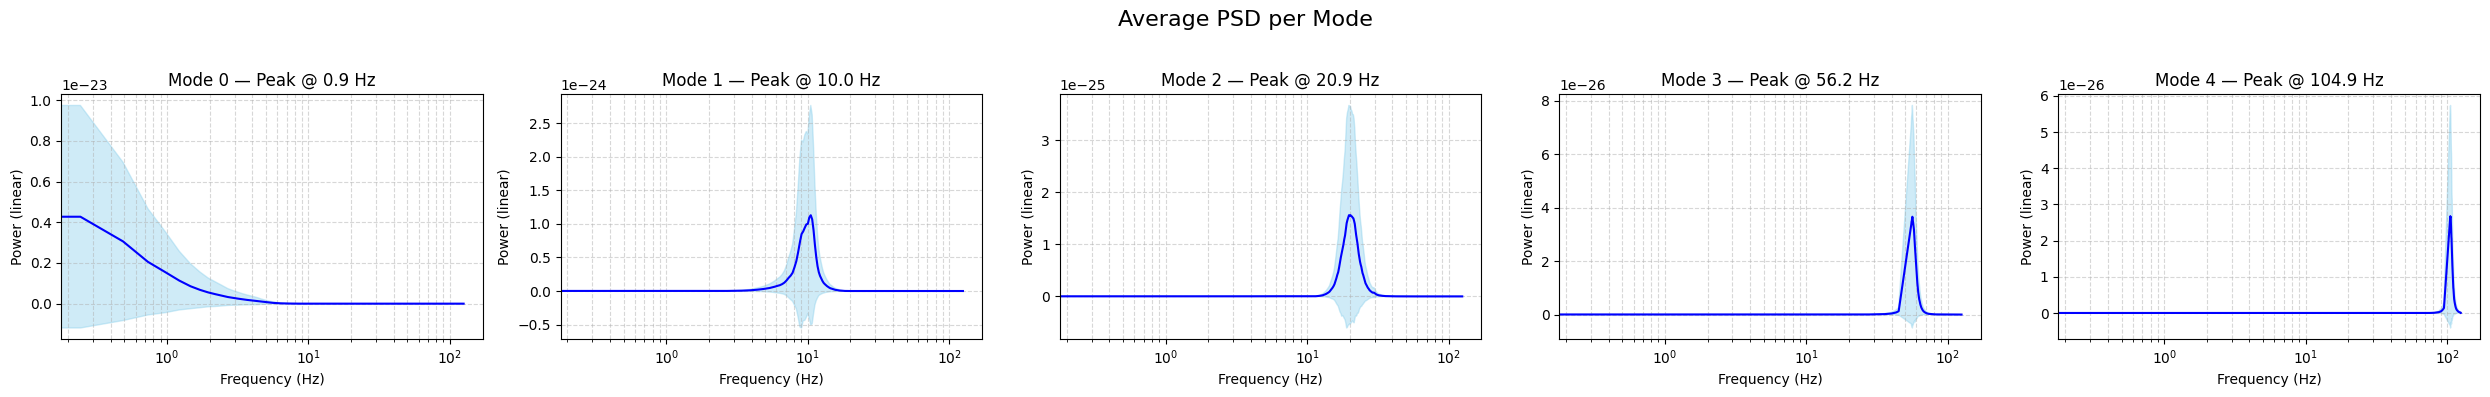

In [135]:
plot_mean_mode_psds(
    modes=u,
    sfreq=fs,
    omega=omega,
    standardize=False,
    notch=True,
    scale='linear',         # or 'db'
    layout='horizental',      # or 'horizontal'
    suptitle="Average PSD per Mode"
)


In [207]:
def plot_mvmd_grid(
    original,
    modes,
    omega,
    fs,
    selected_channels,
    max_points=1000,
    duration=None,
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=1e-10,
    log_psd=True,
    log_freq=True
):
    """
    Plot:
    - Original signal per channel (row 0)
    - MVMD mode per channel (rows 1..n_modes)
    - Mean PSD per mode (last column)

    Parameters:
    - standardize_time: whether to z-score signals in time plots
    - standardize_psd: whether to z-score before PSD computation
    - notch: apply double notch filtering before PSD
    - eps: small value to prevent division by zero or log(0)
    """
    n_modes, n_samples, n_channels = modes.shape

    if duration:
        n_samples = min(n_samples, int(duration * fs))
        original = original[:, :n_samples]
        modes = modes[:, :n_samples, :]

    step = max(1, int(n_samples / max_points)) if max_points else 1
    t = np.arange(0, n_samples, step) / fs

    ncols = len(selected_channels) + 1
    nrows = n_modes + 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 2.2 * nrows), sharex=False)
    if ncols == 2:
        axes = axes.T
    axes = np.array(axes).reshape(nrows, ncols)

    # === Original signal ===
    for j, ch in enumerate(selected_channels):
        x = original[ch]
        x_ds = x[::step]
        axes[0, j].plot(t, x_ds, color='black')
        axes[0, j].set_title(f"Original — Ch {ch}")
        axes[0, j].set_xlabel("Time (s)")
        axes[0, j].set_ylabel("Amplitude")
        axes[0, j].grid(True)
    axes[0, -1].axis('off')

    # === Modes and PSD ===
    for i in range(n_modes):
        all_psd = []

        for j, ch in enumerate(selected_channels):
            y = modes[i, :n_samples, ch]
            y_ds = y[::step]

            # === Standardize for time plot ===
            if standardize_time:
                y_ds = (y_ds - np.mean(y_ds)) / (np.std(y_ds) + eps)

            axes[i+1, j].plot(t, y_ds)
            axes[i+1, j].set_title(f"Mode {i+1} — Ch {ch}")
            axes[i+1, j].set_xlabel("Time (s)")
            axes[i+1, j].set_ylabel("Amplitude")
            axes[i+1, j].grid(True)

            # === PSD preprocessing ===
            y_psd = y.copy()
            if notch:
                y_psd = double_notch(y_psd, fs)
            if standardize_psd:
                y_psd = (y_psd - np.mean(y_psd)) / (np.std(y_psd) + eps)

            f, psd = welch(y_psd, fs=fs, nperseg=fs*2)
            mask = ~((f > 45) & (f < 55)) & ~((f > 95) & (f < 105))
            all_psd.append(psd[mask])

        all_psd = np.array(all_psd) + eps  # prevent log(0)
        mean_psd = np.mean(all_psd, axis=0)
        std_psd = np.std(all_psd, axis=0)
        f_masked = f[mask]

        if log_psd:
            mean_val = 10 * np.log10(mean_psd)
            std_val = 10 * np.log10(mean_psd + std_psd) - mean_val
            ylabel = "Power (dB)"
        else:
            mean_val = mean_psd
            std_val = std_psd
            ylabel = "Power"

        ax = axes[i+1, -1]
        ax.plot(f_masked, mean_val, color="black")
        ax.fill_between(f_masked, mean_val - std_val, mean_val + std_val, color="gray", alpha=0.3)
        ax.set_title(f"PSD — Mode {i+1}")
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel(ylabel)
        if log_freq:
            ax.set_xscale("log")
        ax.grid(True, which="both", ls="--", alpha=0.5)

    plt.suptitle("MVMD Decomposition per Channel + Mean PSD", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


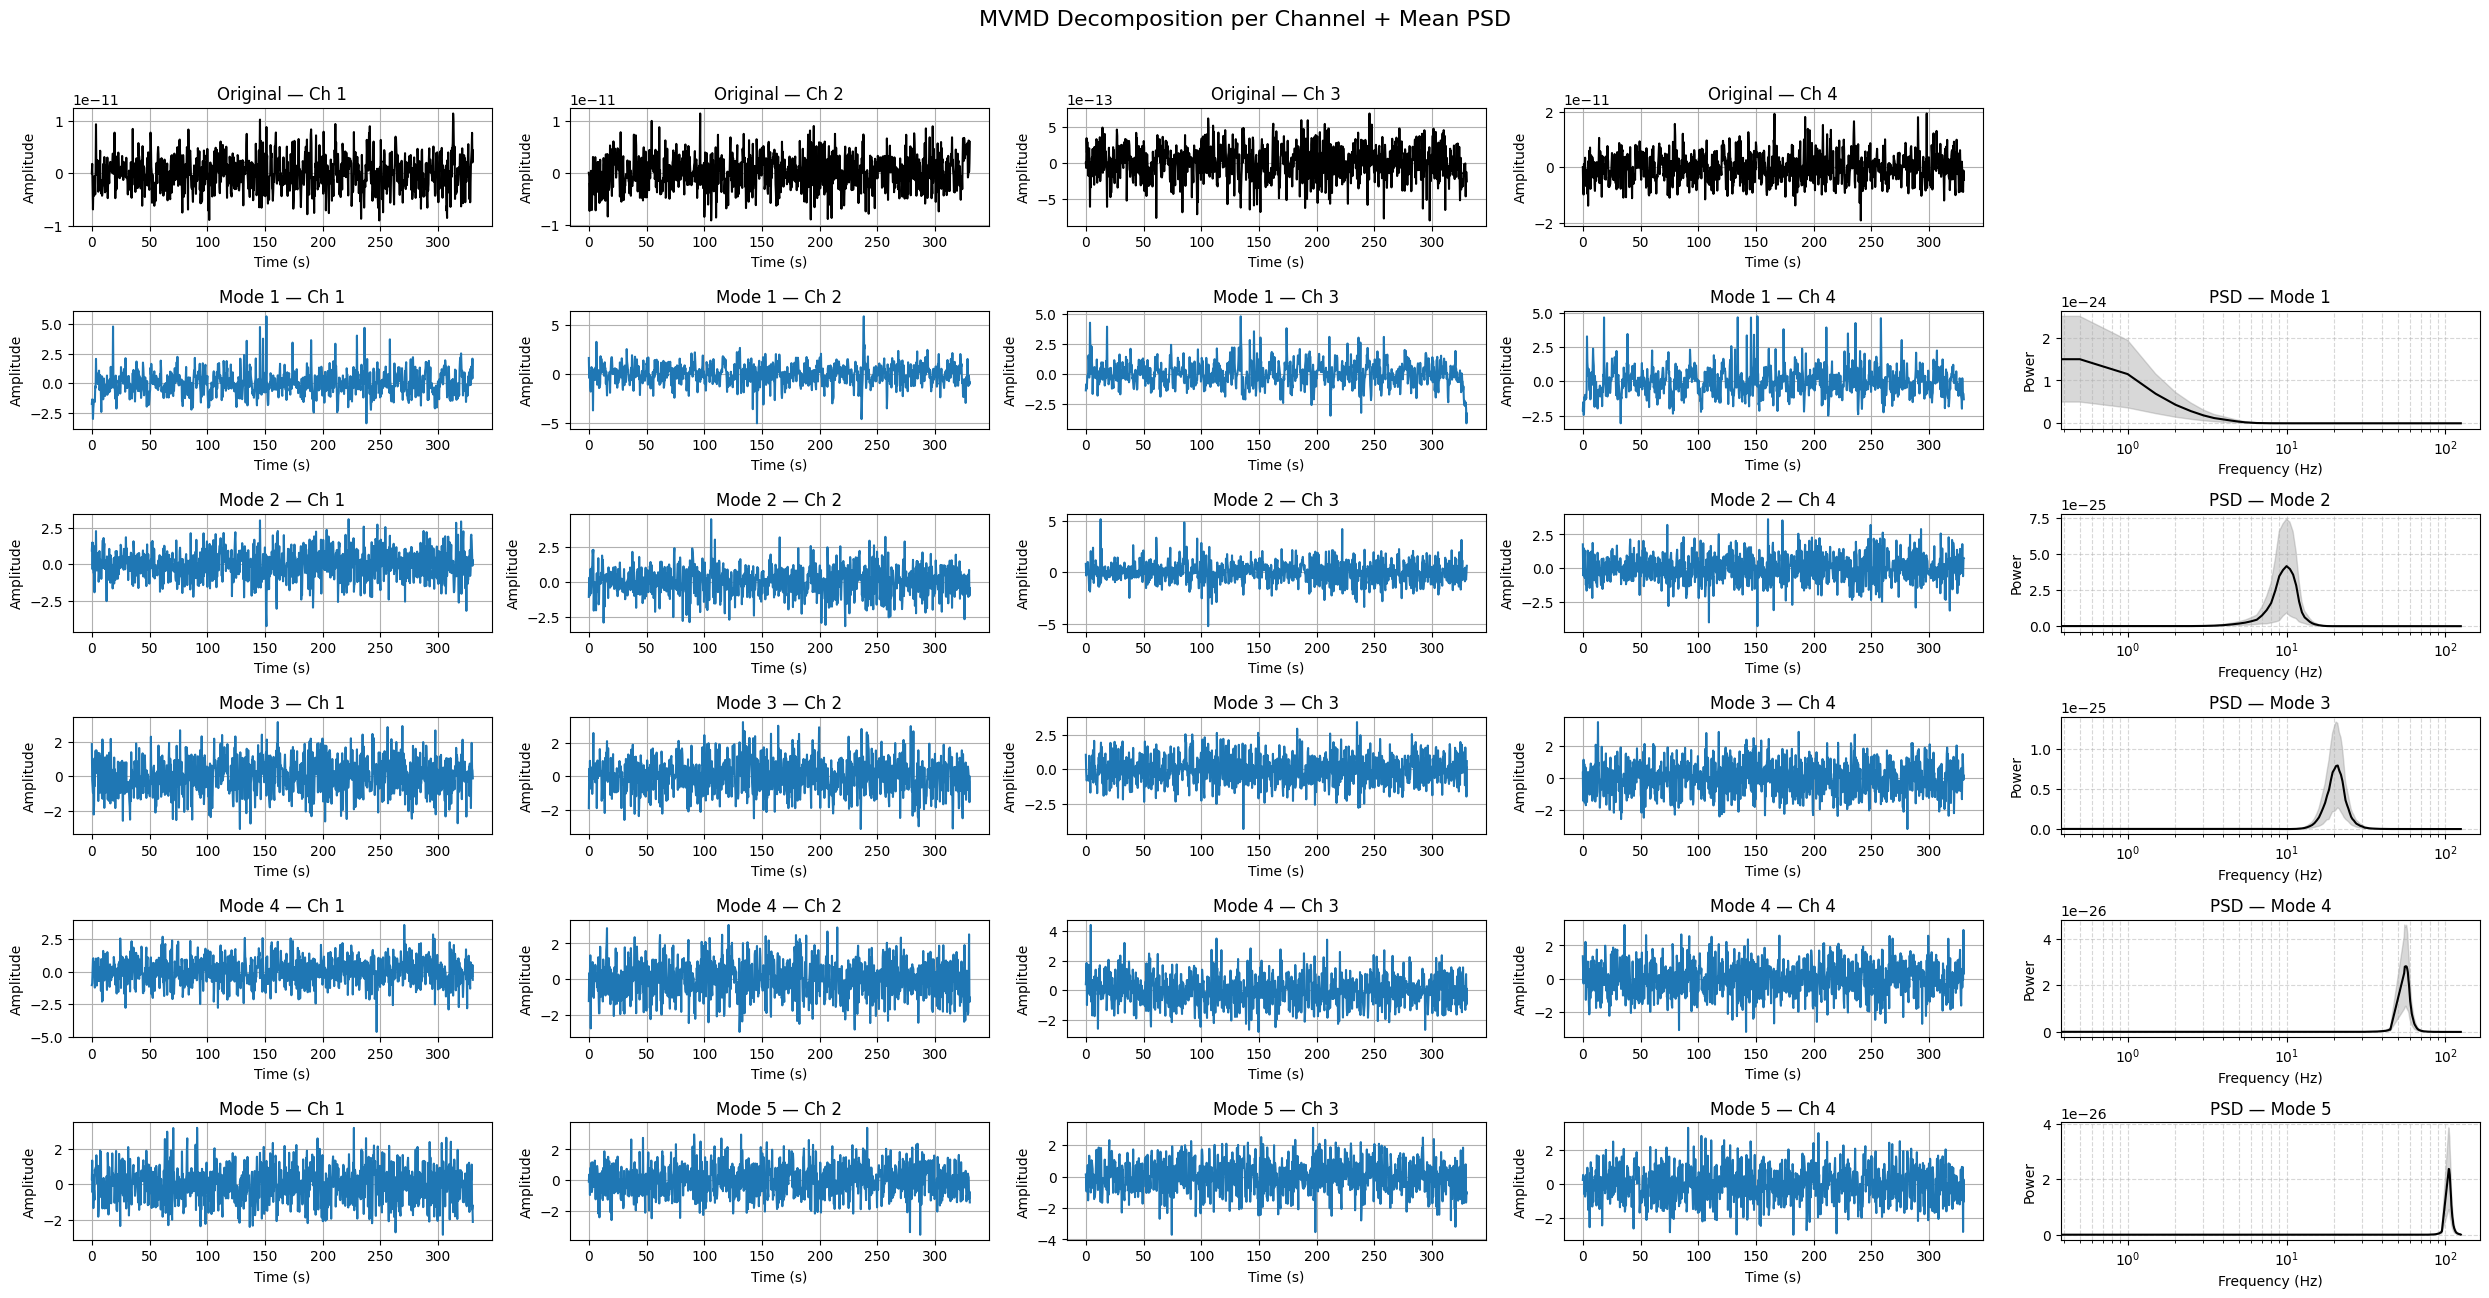

In [208]:
# Select channels to display
selected_channels = [1, 2, 3,4]  # or any list of valid indices

plot_mvmd_grid(
    original=data,
    modes=u,
    omega=omega,
    fs=fs,
    selected_channels=selected_channels,
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=0,
    log_psd=False
)



In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import welch

def plot_mvmd_grid(
    original,
    modes,
    omega,
    fs,
    selected_channels,
    max_points=1000,
    duration=None,
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=1e-10,
    log_psd=True,
    log_freq=True
):
    """
    Plot:
    - Original signal per channel (row 0)
    - MVMD mode per channel (rows 1..n_modes)
    - Mean PSD per mode (last column)

    Parameters:
    - standardize_time: whether to z-score signals in time plots
    - standardize_psd: whether to z-score before PSD computation
    - notch: apply double notch filtering before PSD
    - eps: small value to prevent division by zero or log(0)
    """
    n_modes, n_samples, n_channels = modes.shape

    if duration:
        n_samples = min(n_samples, int(duration * fs))
        original = original[:, :n_samples]
        modes = modes[:, :n_samples, :]

    step = max(1, int(n_samples / max_points)) if max_points else 1
    t = np.arange(0, n_samples, step) / fs

    ncols = len(selected_channels) + 1
    nrows = n_modes + 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 2.2 * nrows), sharex=False)
    if ncols == 2:
        axes = axes.T
    axes = np.array(axes).reshape(nrows, ncols)

    mode_colors = sns.color_palette("husl", n_modes)

    # === Original signal (row 0) ===
    for j, ch in enumerate(selected_channels):
        x = original[ch]
        x_ds = x[::step]
        axes[0, j].plot(t, x_ds, color='black')
        axes[0, j].set_title(f"Ch {ch}")
        axes[0, j].set_xlabel("Time (s)")
        axes[0, j].grid(True)
        if j == 0:
            axes[0, j].set_ylabel("Original")

    axes[0, -1].axis('off')

    # === Modes and PSD ===
    for i in range(n_modes):
        all_psd = []
        mode_color = mode_colors[i]

        for j, ch in enumerate(selected_channels):
            y = modes[i, :n_samples, ch]
            y_ds = y[::step]

            if standardize_time:
                y_ds = (y_ds - np.mean(y_ds)) / (np.std(y_ds) + eps)

            axes[i+1, j].plot(t, y_ds, color=mode_color)
            axes[i+1, j].set_xlabel("Time (s)")
            axes[i+1, j].grid(True)
            if j == 0:
                axes[i+1, j].set_ylabel(f"Mode {i+1}")

            y_psd = y.copy()
            if notch:
                y_psd = double_notch(y_psd, fs)
            if standardize_psd:
                y_psd = (y_psd - np.mean(y_psd)) / (np.std(y_psd) + eps)

            f, psd = welch(y_psd, fs=fs, nperseg=fs*2)
            mask = ~((f > 45) & (f < 55)) & ~((f > 95) & (f < 105))
            all_psd.append(psd[mask])

        all_psd = np.array(all_psd) + eps
        mean_psd = np.mean(all_psd, axis=0)
        std_psd = np.std(all_psd, axis=0)
        f_masked = f[mask]

        if log_psd:
            mean_val = 10 * np.log10(mean_psd)
            std_val = 10 * np.log10(mean_psd + std_psd) - mean_val
            ylabel = "Power (dB)"
        else:
            mean_val = mean_psd
            std_val = std_psd
            ylabel = "Power"
            if np.any(mean_val <= 0):
                mean_val = np.clip(mean_val, a_min=eps, a_max=None)

        ax = axes[i+1, -1]
        ax.plot(f_masked, mean_val, color=mode_color)
        ax.fill_between(f_masked, mean_val - std_val, mean_val + std_val, color=mode_color, alpha=0.3)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel(ylabel)
        if log_freq:
            ax.set_xscale("log")
        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.set_title(f"PSD — Mode {i+1}")

    plt.suptitle("MVMD Decomposition per Channel + Mean PSD", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


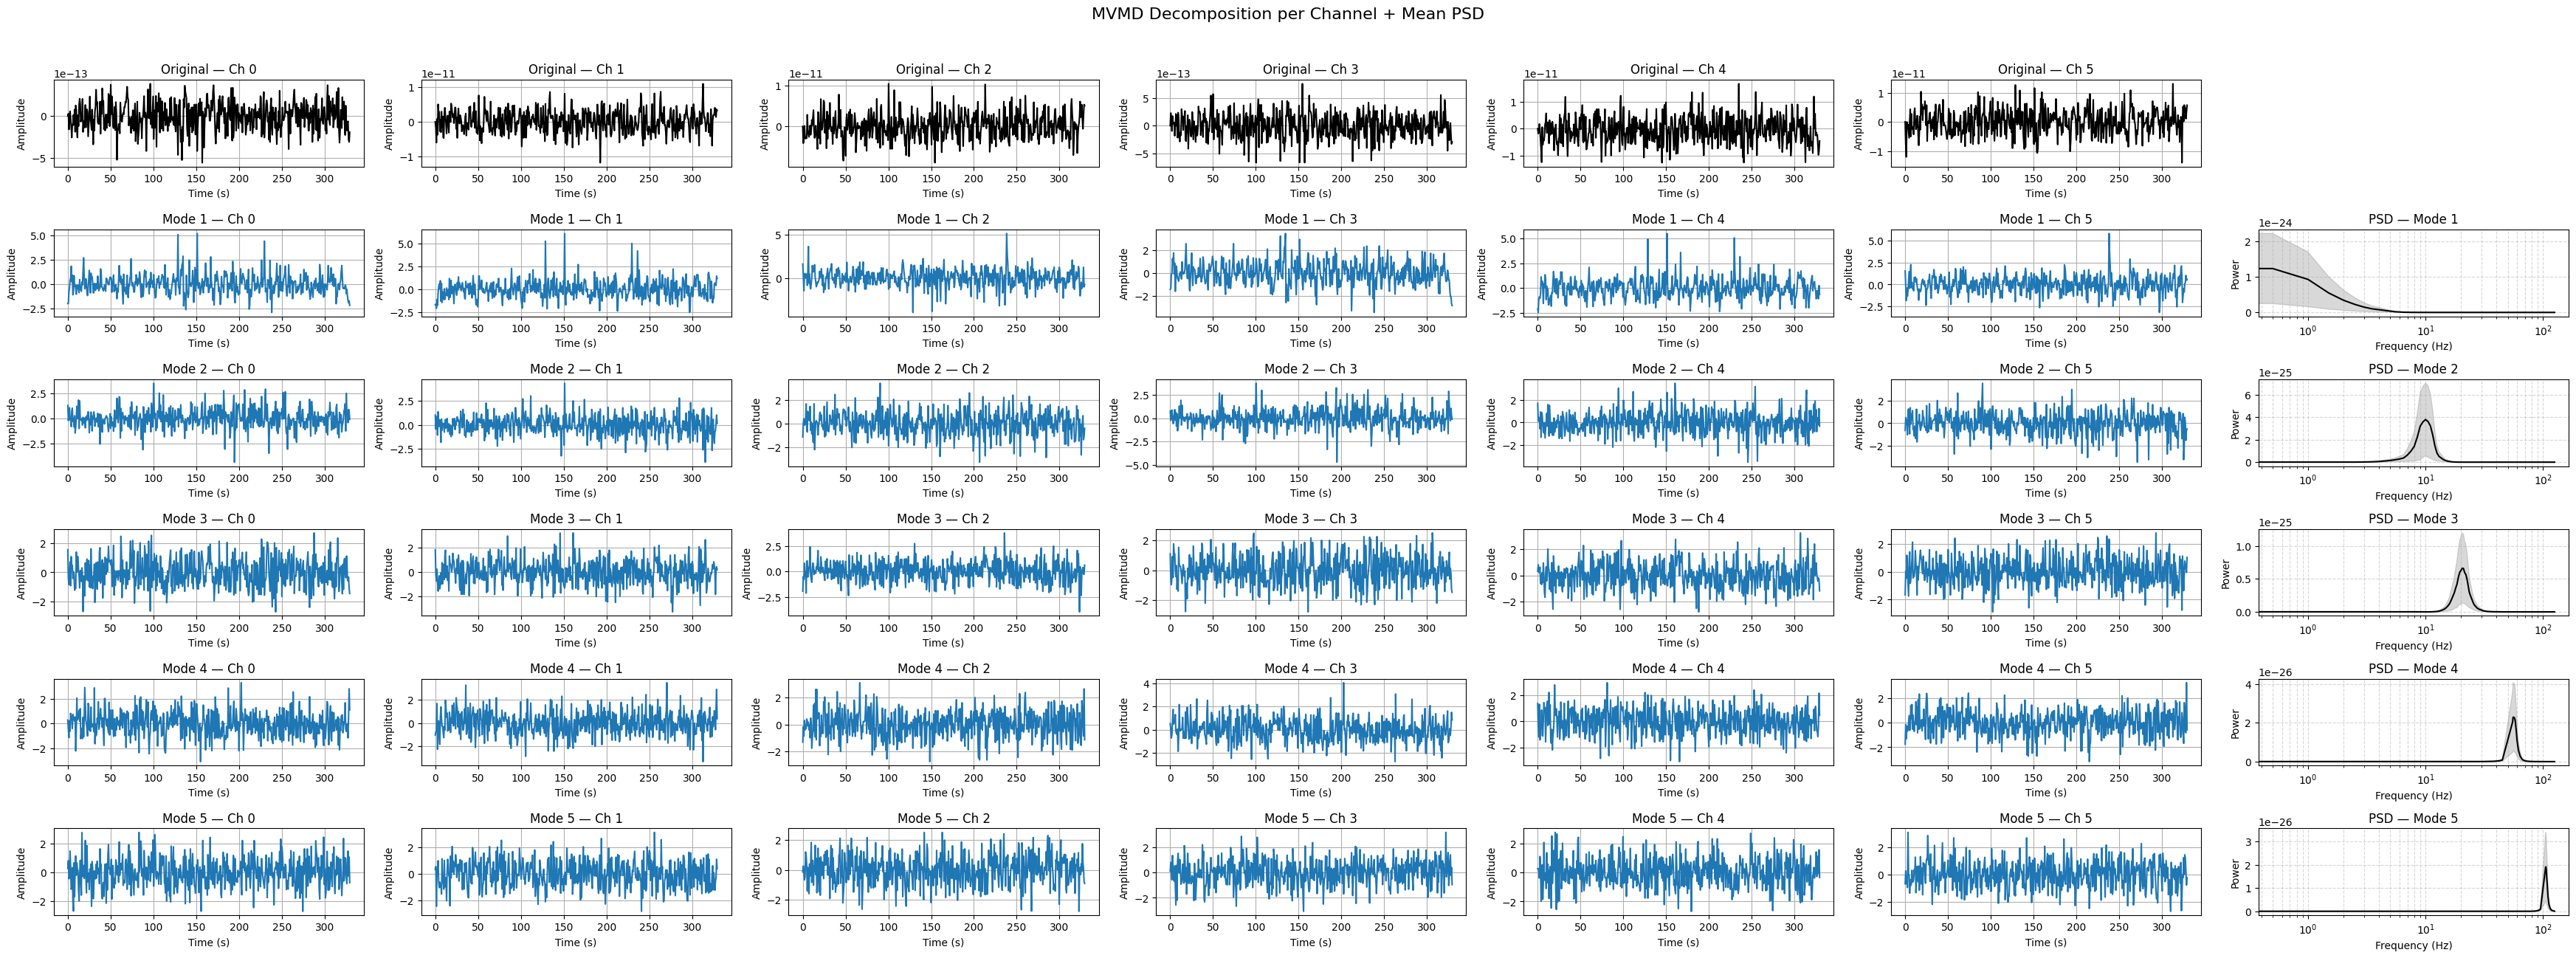

In [209]:
plot_mvmd_grid(
    original=data,
    modes=u,
    omega=omega,
    fs=250,  # or your actual sampling rate
    selected_channels=[0, 1,2,3,4,5],  # or any list of channel names
    max_points=500,
    duration=330,  # or None to plot all
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=0,
    log_psd=False,   # or False for linear scale
    log_freq=True   # or False if you want linear freq
)





In [228]:
def plot_mvmd_grid(
    original,
    modes,
    omega,
    fs,
    selected_channels,
    max_points=1000,
    duration=None,
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=1e-10,
    log_psd=True,
    log_freq=True
):
    n_modes, n_samples, n_channels = modes.shape

    if duration:
        n_samples = min(n_samples, int(duration * fs))
        original = original[:, :n_samples]
        modes = modes[:, :n_samples, :]

    step = max(1, int(n_samples / max_points)) if max_points else 1
    t = np.arange(0, n_samples, step) / fs

    ncols = len(selected_channels) + 1  # +1 for PSD
    nrows = n_modes + 1  # +1 for original

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 2.2 * nrows), sharex=False)
    # Force shape (nrows, ncols) — always 2D array
    if nrows == 1:
        axes = axes[np.newaxis, :]
    elif ncols == 1:
        axes = axes[:, np.newaxis]
    axes = np.array(axes).reshape(nrows, ncols)    
    mode_colors = sns.color_palette("husl", n_modes)

    # === COLUMN TITLES ===
    for j in range(len(selected_channels)):
        axes[0, j].set_title(f"Channel {j+1}", fontsize=11)
    axes[0, -1].set_title("Mean PSD", fontsize=11)

    # === ROW LABELS ===
    axes[0, 0].set_ylabel("Original", fontsize=11)
    for i in range(n_modes):
        axes[i + 1, 0].set_ylabel(f"Mode {i+1}", fontsize=11)

    # === ORIGINAL SIGNALS ===
    for j, ch in enumerate(selected_channels):
        x = original[ch]
        x_ds = x[::step]
        axes[0, j].plot(t, x_ds, color='black')
        axes[0, j].set_xlabel("Time (s)")
        axes[0, j].grid(True)
    axes[0, -1].axis('off')  # last col for original row = PSD placeholder

    # === MODES + PSD ===
    for i in range(n_modes):
        all_psd = []
        mode_color = mode_colors[i]

        for j, ch in enumerate(selected_channels):
            y = modes[i, :n_samples, ch]
            y_ds = y[::step]

            if standardize_time:
                y_ds = (y_ds - np.mean(y_ds)) / (np.std(y_ds) + eps)

            axes[i+1, j].plot(t, y_ds, color=mode_color)
            axes[i+1, j].set_xlabel("Time (s)")
            axes[i+1, j].grid(True)

            # === PSD Prep ===
            y_psd = y.copy()
            if notch:
                y_psd = double_notch(y_psd, fs)
            if standardize_psd:
                y_psd = (y_psd - np.mean(y_psd)) / (np.std(y_psd) + eps)

            f, psd = welch(y_psd, fs=fs, nperseg=fs * 2)
            mask = ~((f > 45) & (f < 55)) & ~((f > 95) & (f < 105))
            all_psd.append(psd[mask])

        # === PSD Plot ===
        all_psd = np.array(all_psd) + eps
        mean_psd = np.mean(all_psd, axis=0)
        std_psd = np.std(all_psd, axis=0)
        f_masked = f[mask]

        if log_psd:
            mean_val = 10 * np.log10(mean_psd)
            std_val = 10 * np.log10(mean_psd + std_psd) - mean_val
            ylabel = "Power (dB)"
        else:
            mean_val = mean_psd
            std_val = std_psd
            ylabel = "Power"
            mean_val = np.clip(mean_val, a_min=eps, a_max=None)

        ax = axes[i+1, -1]
        ax.plot(f_masked, mean_val, color=mode_color)
        ax.fill_between(f_masked, mean_val - std_val, mean_val + std_val, color=mode_color, alpha=0.3)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel(ylabel)
        if log_freq:
            ax.set_xscale("log")
        ax.grid(True, which="both", ls="--", alpha=0.5)

    plt.suptitle("MVMD Decomposition per Channel + Mean PSD", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.subplots_adjust(wspace=0.3, hspace=0.5)  # tweak as needed
    plt.show()


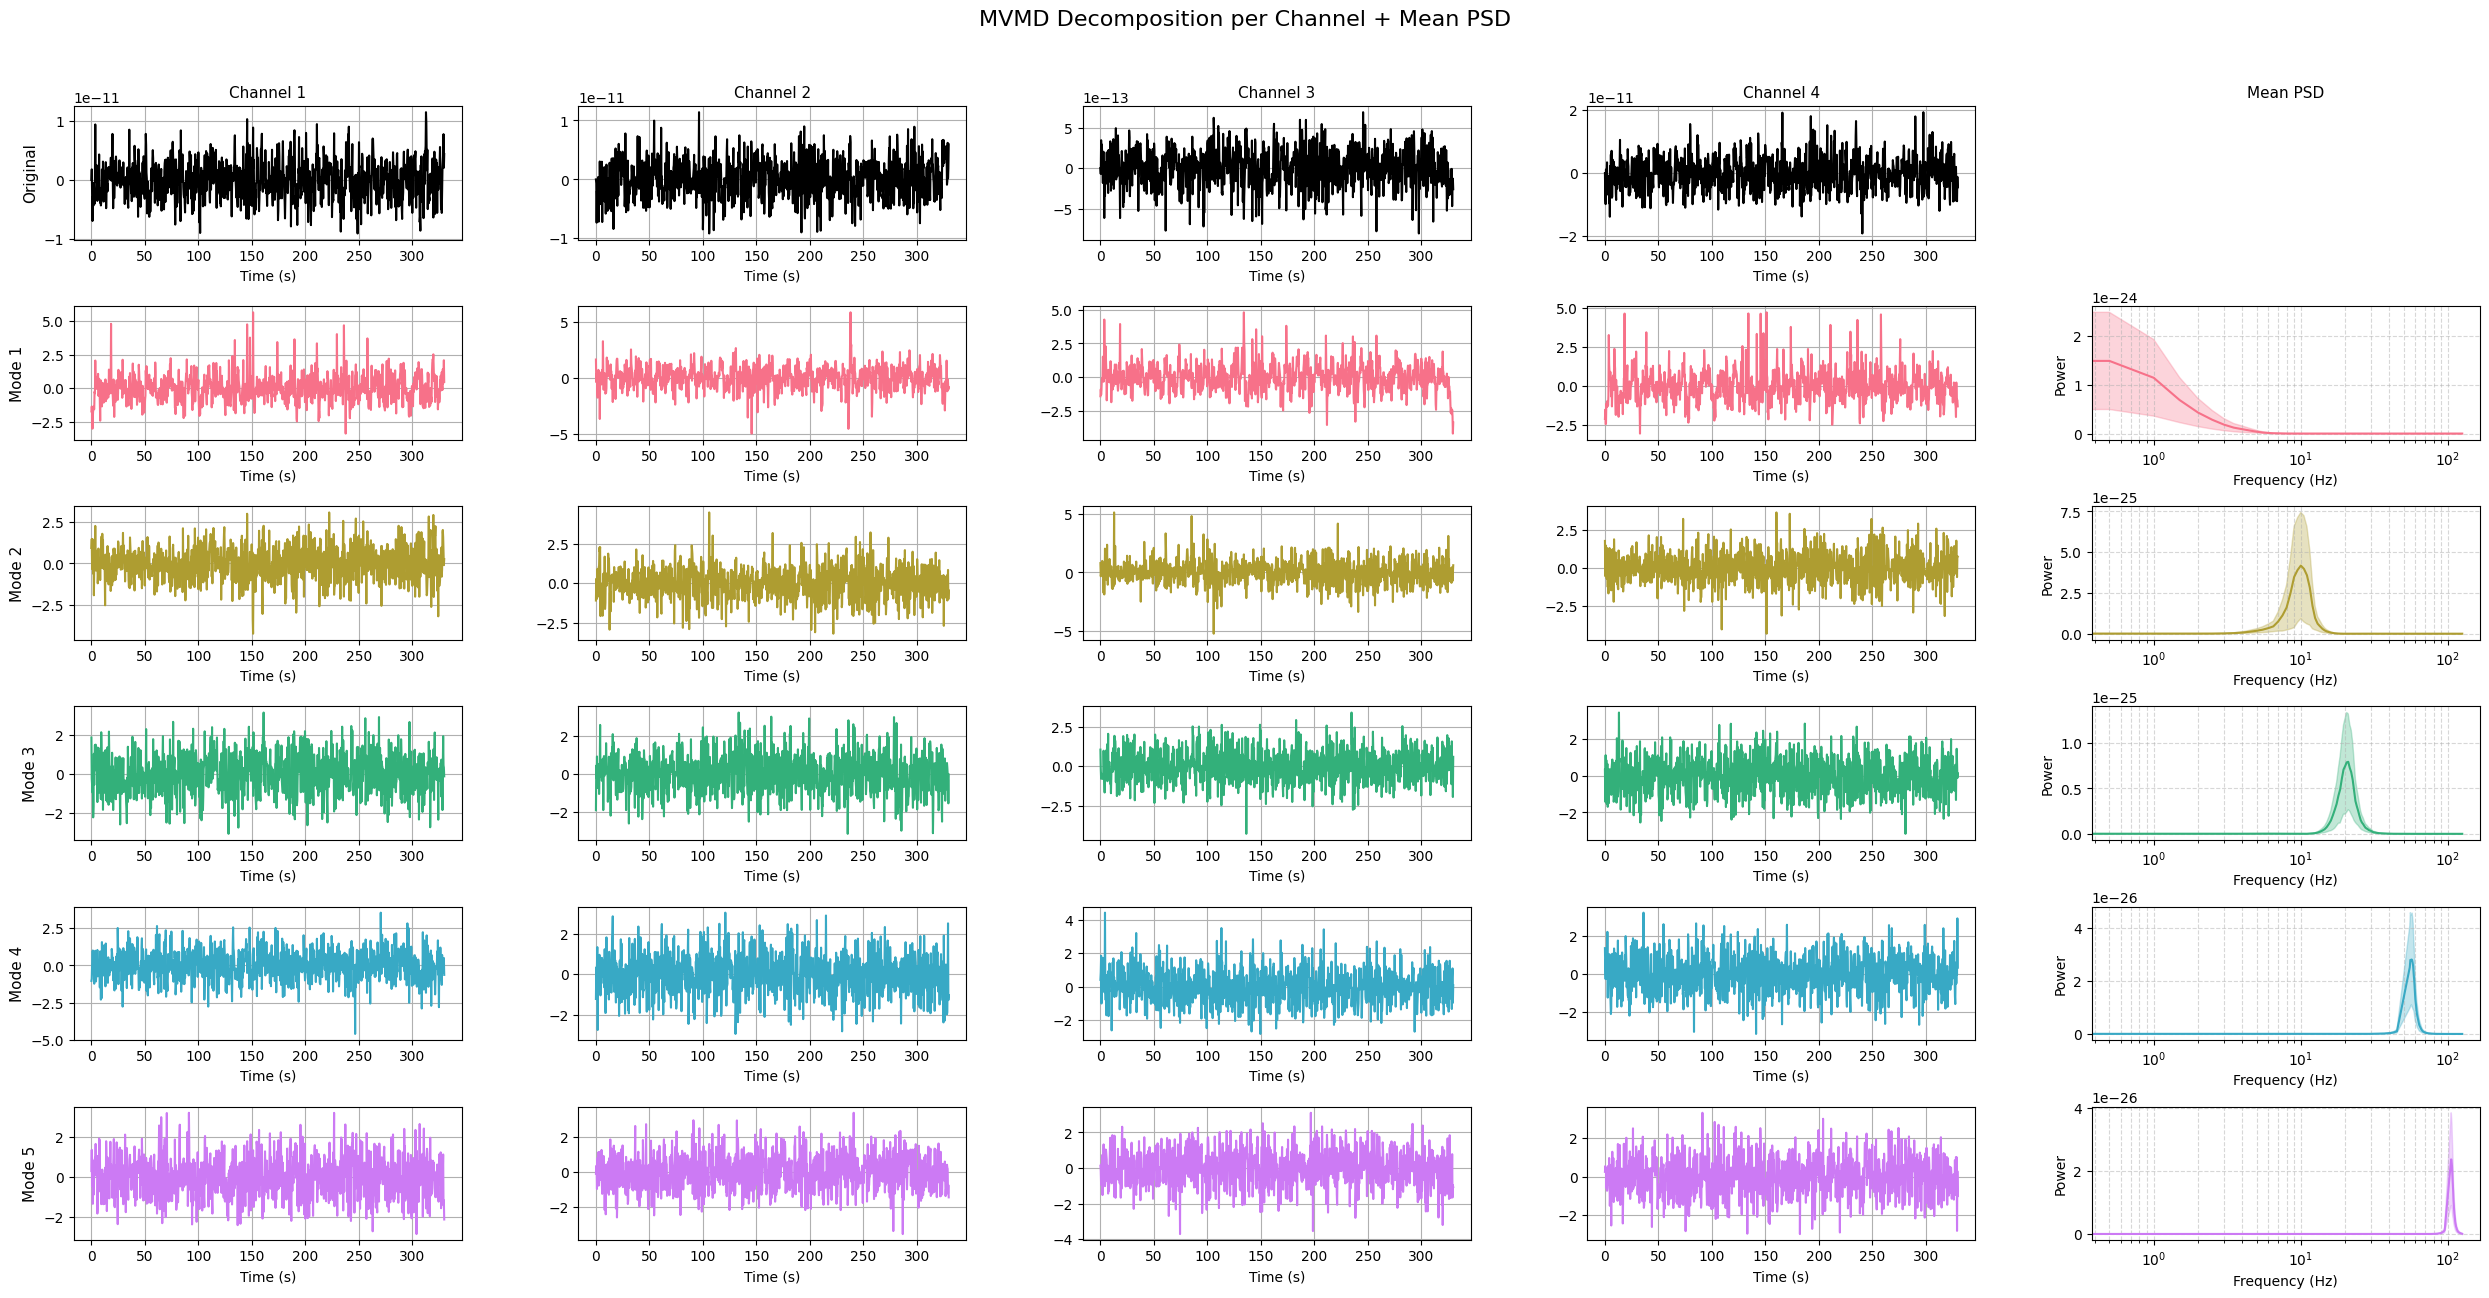

In [229]:
plot_mvmd_grid(
    original=data,
    modes=u,
    omega=omega,
    fs=250,  # or your actual sampling rate
    selected_channels=[1,2,3,4],  # or any list of channel names
    max_points=1000,
    duration=330,  # or None to plot all
    standardize_time=True,
    standardize_psd=False,
    notch=True,
    eps=0,
    log_psd=False,   # or False for linear scale
    log_freq=True   # or False if you want linear freq
)


In [236]:


def plot_mode_corr_matrix(
    corr_matrix,
    title="Average Mode Correlation Across Channels",
    cmap="coolwarm",
    figsize=(7, 6),
    mode_names=None,
    fontsize=12,
):
    """
    Plot a clean Seaborn heatmap of the mode correlation matrix.

    Parameters:
    - corr_matrix: square (n_modes x n_modes) matrix
    - title: title of the plot
    - cmap: color palette
    - figsize: figure size
    - mode_names: optional list of labels (e.g., ["Delta", "Theta", ...])
    - fontsize: font size for labels and annotations
    """
    n_modes = corr_matrix.shape[0]
    if mode_names is None:
        mode_names = [f"Mode {i+1}" for i in range(n_modes)]

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        square=True,
        xticklabels=mode_names,
        yticklabels=mode_names,
        linewidths=0.5,
        linecolor='white',
        cbar_kws={"label": "Correlation"},
        vmin=0, vmax=1
    )

    ax.set_title(title, fontsize=fontsize + 2, weight='bold', pad=20)
    ax.set_xlabel("Mode Indexes", fontsize=fontsize)
    ax.set_ylabel("Mode Indexes", fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    plt.tight_layout()
    plt.show()


def compute_mode_corr_matrix_across_channels(u):
    """
    Compute the average correlation matrix between modes across all channels.

    Parameters:
    - u: ndarray of shape (n_modes, n_samples, n_channels)

    Returns:
    - corr_matrix: average correlation matrix of shape (n_modes, n_modes)
    """
    n_modes, n_samples, n_channels = u.shape
    corr_matrices = []

    for ch in range(n_channels):
        data = u[:, :, ch]  # shape: (n_modes, n_samples)
        corr = np.corrcoef(data)
        corr_matrices.append(corr)

    # Average across channels
    corr_matrix = np.mean(corr_matrices, axis=0)
    return corr_matrix



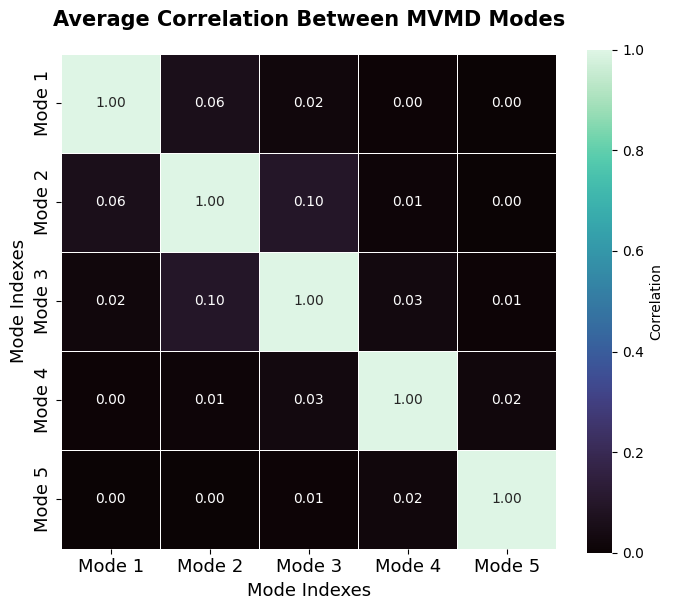

In [237]:
corr_matrix = compute_mode_corr_matrix_across_channels(u)

plot_mode_corr_matrix(
    corr_matrix,
    title="Average Correlation Between MVMD Modes",
    cmap="mako",  # Try "viridis", "mako", or "plasma" too
    mode_names=[f"Mode {i+1}" for i in range(u.shape[0])],
    fontsize=13
)


In [ ]:
from matplotlib.ticker import LogLocator, FuncFormatter


def plot_mode_psds_db_multi_channel_modes_first(
    modes, 
    sfreq, 
    channel_indices=None, 
    standardize_time=False,
    standardize_psd=False,
    notch=True,
    log_scale=False,
    eps=1e-12
):
    """
    Plot PSDs (in dB) for each mode across selected channels.
    
    modes shape: (n_modes, n_samples, n_channels)
    """
    n_modes, n_samples, n_channels = modes.shape

    if channel_indices is None:
        channel_indices = list(range(n_channels))

    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10.colors
    handles = []

    for mode_idx in range(n_modes):
        color = colors[mode_idx % len(colors)]
        psds_list = []

        for ch in channel_indices:
            signal = modes[mode_idx, :, ch]

            if standardize_time:
                signal = (signal - np.mean(signal)) / (np.std(signal) + eps)

            freqs, psd = welch(signal, fs=sfreq, nperseg=min(1024, n_samples))

            if notch:
                mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
                freqs = freqs[mask]
                psd = psd[mask]

            psd_db = 10 * np.log10(psd + eps)
            psds_list.append(psd_db)

        psds_array_db = np.array(psds_list)

        if standardize_psd:
            psds_array_db = (psds_array_db - np.mean(psds_array_db, axis=0)) / (np.std(psds_array_db, axis=0) + eps)

        for psd_curve_db in psds_array_db:
            plt.plot(freqs, psd_curve_db, color=color, alpha=0.3)

        handles.append(plt.Line2D([], [], color=color, label=f"Mode {mode_idx + 1}"))

    ch_str = ", ".join(str(ch) for ch in channel_indices)
    plt.title(f"PSD (dB) per Mode across channels {ch_str}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB)")

    if log_scale:
        plt.xscale("log")
        ax = plt.gca()
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$'))

    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend(handles=handles, title="Modes")
    plt.tight_layout()
    plt.show()


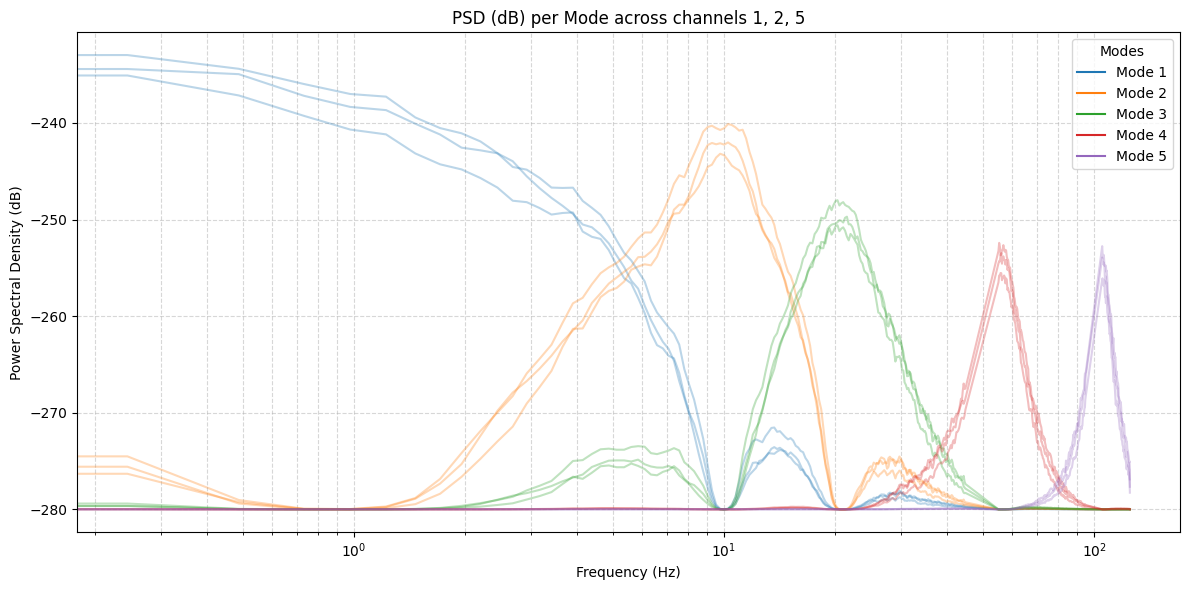

In [ ]:
plot_mode_psds_db_multi_channel_modes_first(
    u,                 # shape: (5, 82500, 306)
    sfreq=250,
    channel_indices=[1, 2, 5],
    standardize_time=False,
    standardize_psd=False,
    notch=True,
    log_scale=True,
    eps=1e-28

)


In [262]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter
from scipy.signal import welch
import numpy as np

def plot_mode_psds_multi_channel_modes_first(
    modes, 
    sfreq, 
    channel_indices=None, 
    standardize_time=False,
    standardize_psd=False,
    notch=True,
    log_scale=False,
    db_scale=True,      # New toggle here
    eps=1e-12
):
    """
    Plot PSDs (in dB or linear) for each mode across selected channels.

    Parameters:
    - modes: np.ndarray (n_modes, n_samples, n_channels)
    - sfreq: float, sampling frequency
    - channel_indices: list of channel indices (default: all)
    - standardize_time: z-score time series
    - standardize_psd: z-score PSD across channels
    - notch: mask 50/100Hz bands
    - log_scale: apply log scale to X-axis
    - db_scale: if True, use dB (10*log10). Else linear scale
    - eps: small number to avoid log(0)
    """
    n_modes, n_samples, n_channels = modes.shape

    if channel_indices is None:
        channel_indices = list(range(n_channels))

    fig, axes = plt.subplots(1, n_modes, figsize=(5 * n_modes, 4))  # No sharey
    if n_modes == 1:
        axes = [axes]

    colors = plt.cm.tab10.colors

    for mode_idx in range(n_modes):
        ax = axes[mode_idx]
        psds_list = []

        for i, ch in enumerate(channel_indices):
            signal = modes[mode_idx, :, ch]

            if standardize_time:
                signal = (signal - np.mean(signal)) / (np.std(signal) + eps)

            freqs, psd = welch(signal, fs=sfreq, nperseg=min(1024, n_samples))

            if notch:
                mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
                freqs = freqs[mask]
                psd = psd[mask]

            if db_scale:
                psd_to_plot = 10 * np.log10(psd + eps)
            else:
                psd_to_plot = psd

            psds_list.append(psd_to_plot)

            ch_color = colors[i % len(colors)]
            ax.plot(freqs, psd_to_plot, color=ch_color, alpha=1.0, label=f"Ch {ch}")

        psds_array = np.array(psds_list)

        if standardize_psd:
            psds_array = (psds_array - np.mean(psds_array, axis=0)) / (np.std(psds_array, axis=0) + eps)

        ax.set_title(f"Mode {mode_idx + 1}")
        ax.set_xlabel("Frequency (Hz)")
        ax.grid(True, which="both", ls="--", alpha=0.5)

        if log_scale:
            ax.set_xscale("log")
            ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'$10^{{{int(np.log10(x))}}}$'))

        if mode_idx == 0:
            ax.set_ylabel("Power (dB)" if db_scale else "Power (Linear)")

    # Legend
    handles = [plt.Line2D([0], [0], color=colors[i % len(colors)], label=f"Ch {ch}") 
               for i, ch in enumerate(channel_indices)]

    fig.legend(handles=handles, loc='lower center', ncol=len(channel_indices), title="Channels", frameon=False)

    ch_str = ", ".join(str(ch) for ch in channel_indices)
    fig.suptitle(f"PSD per Mode — Channels {ch_str}", fontsize=15, weight='bold')

    plt.tight_layout(rect=[0, 0.12, 1, 0.92])
    plt.show()


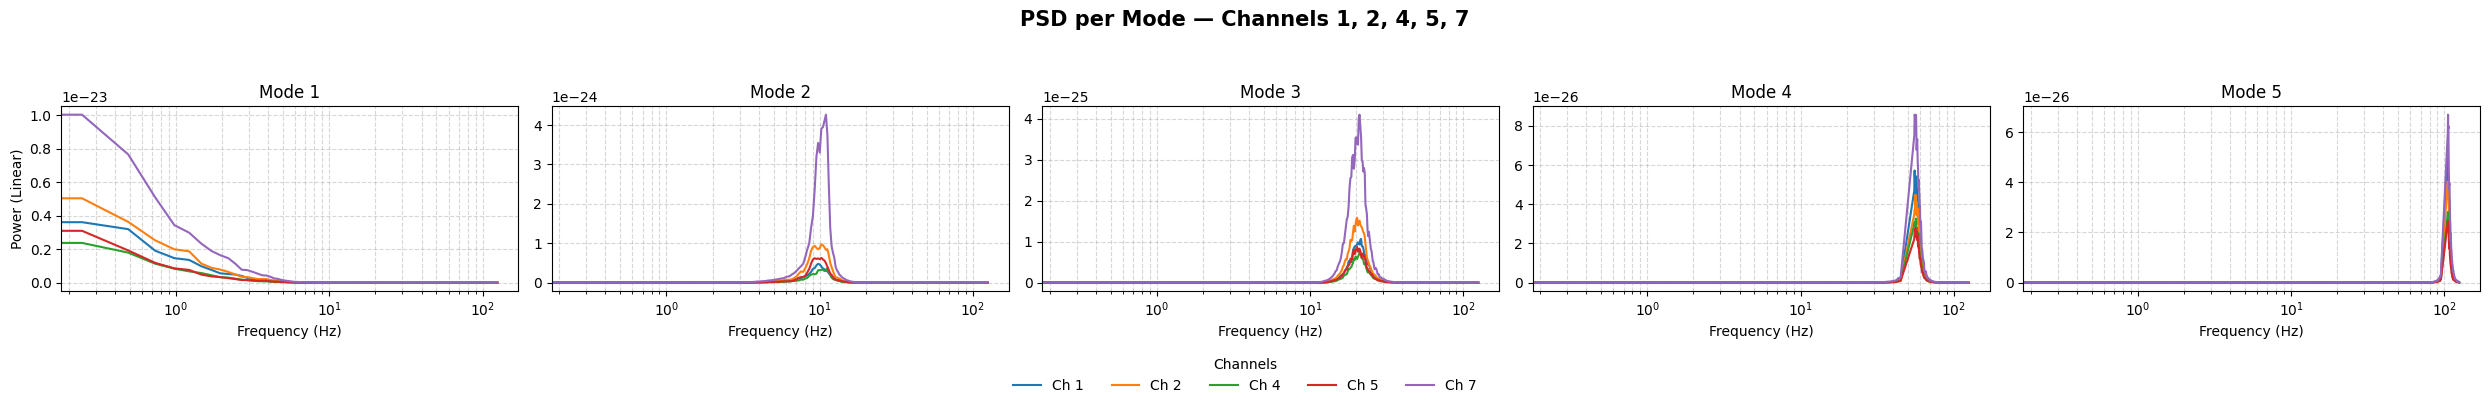

In [263]:

plot_mode_psds_multi_channel_modes_first(
    modes=u,
    sfreq=250,
    channel_indices=[1, 2,4,5,7],
    db_scale=False,
    standardize_psd=False,
    notch=True,
    log_scale=True,
    eps=0
)


## 3. Enveloppes extraction

In [70]:
omega.real

array([[  0.8732198,   9.975346 ,  20.900143 ,  56.230385 , 104.93458  ]],
      dtype=float32)

In [72]:
omega

array([[  0.8732198+0.j,   9.975346 +0.j,  20.900143 +0.j,
         56.230385 +0.j, 104.93458  +0.j]], dtype=complex64)

In [77]:
# u shape: (n_modes, n_samples, n_channels)
# omega: torch tensor or np.ndarray already in Hz
extract_mvmd_envelopes(
    u=u,  # your MVMD output (n_modes, n_samples, n_channels)
    omega=omega,  # already multiplied by sfreq
    save_dir="../results/real/MVMD/envelopes",  # wherever you want
    sfreq=250
)


✅ Omega (Hz): [  0.8732198   9.975346   20.900143   56.230385  104.93458  ] | Shape: (5,)
🔍 Processing channel 0...
✅ Saved envelopes for channel 0 to ../results/real/MVMD/envelopes/meg_channel_0_envelopes.npy
🔍 Processing channel 1...
✅ Saved envelopes for channel 1 to ../results/real/MVMD/envelopes/meg_channel_1_envelopes.npy
🔍 Processing channel 2...
✅ Saved envelopes for channel 2 to ../results/real/MVMD/envelopes/meg_channel_2_envelopes.npy
🔍 Processing channel 3...
✅ Saved envelopes for channel 3 to ../results/real/MVMD/envelopes/meg_channel_3_envelopes.npy
🔍 Processing channel 4...
✅ Saved envelopes for channel 4 to ../results/real/MVMD/envelopes/meg_channel_4_envelopes.npy
🔍 Processing channel 5...
✅ Saved envelopes for channel 5 to ../results/real/MVMD/envelopes/meg_channel_5_envelopes.npy
🔍 Processing channel 6...
✅ Saved envelopes for channel 6 to ../results/real/MVMD/envelopes/meg_channel_6_envelopes.npy
🔍 Processing channel 7...
✅ Saved envelopes for channel 7 to ../result

In [78]:
def compute_envelope_correlation_per_mode(envelopes):
    """
    Compute correlation matrices for each mode across all channels.

    Parameters
    ----------
    envelopes : np.ndarray
        Array of shape (n_modes, n_timepoints, n_channels)

    Returns
    -------
    dict
        Dictionary with keys = mode index, values = (306 x 306) correlation matrix
    """
    n_modes, n_timepoints, n_channels = envelopes.shape
    corr_dict = {}

    for m in range(n_modes):
        # Transpose to shape (n_channels, n_timepoints)
        data = envelopes[m].T
        corr = np.corrcoef(data)
        corr_dict[m] = corr

    return corr_dict


In [79]:
def plot_correlation_matrix(corr, mode_idx, figsize=(8, 6), cmap="coolwarm", vmin=-1, vmax=1):
    """
    Plot a correlation matrix using seaborn heatmap.

    Parameters
    ----------
    corr : np.ndarray
        Correlation matrix (channels x channels)
    mode_idx : int
        Mode index (for title)
    figsize : tuple
        Figure size
    cmap : str
        Colormap
    vmin : float
        Minimum value for color scale
    vmax : float
        Maximum value for color scale
    """
    plt.figure(figsize=figsize)
    sns.heatmap(corr, cmap=cmap, center=0, vmin=vmin, vmax=vmax,
                square=True, xticklabels=False, yticklabels=False)
    plt.title(f"Envelope Correlation Matrix - Mode {mode_idx}")
    plt.tight_layout()
    plt.show()


In [83]:

def load_all_envelopes(envelopes_dir, n_channels=306):
    """
    Load all envelope .npy files and stack into a single array:
    shape = (n_modes, n_samples, n_channels)
    """
    all_env = []
    for ch in range(n_channels):
        path = os.path.join(envelopes_dir, f"meg_channel_{ch}_envelopes.npy")
        if not os.path.exists(path):
            print(f"⚠️ Missing file: {path}")
            continue
        env = np.load(path)  # shape: (n_modes, n_samples)
        all_env.append(env[..., np.newaxis])  # shape: (n_modes, n_samples, 1)

    # Stack along last axis (channels)
    stacked_env = np.concatenate(all_env, axis=-1)
    return stacked_env


In [84]:
envelopes = load_all_envelopes("../results/real/MVMD/envelopes")

In [85]:
# envelopes shape should be (n_modes, n_timepoints, n_channels)
correlation_matrices = compute_envelope_correlation_per_mode(envelopes)


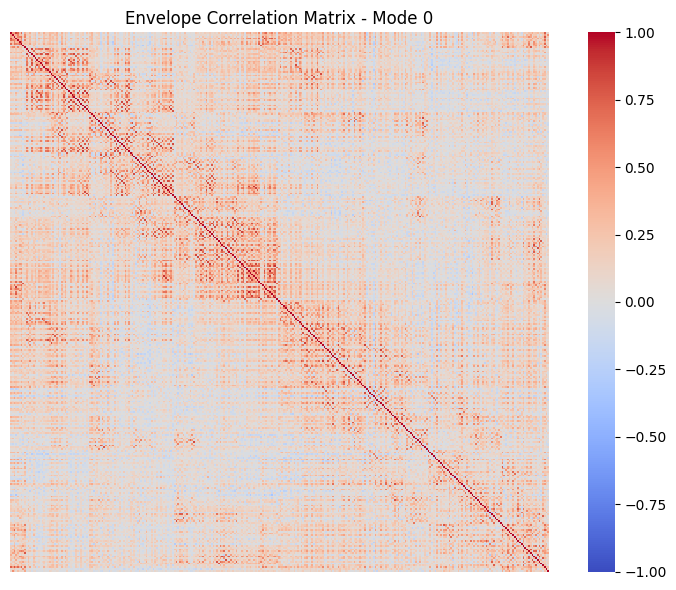

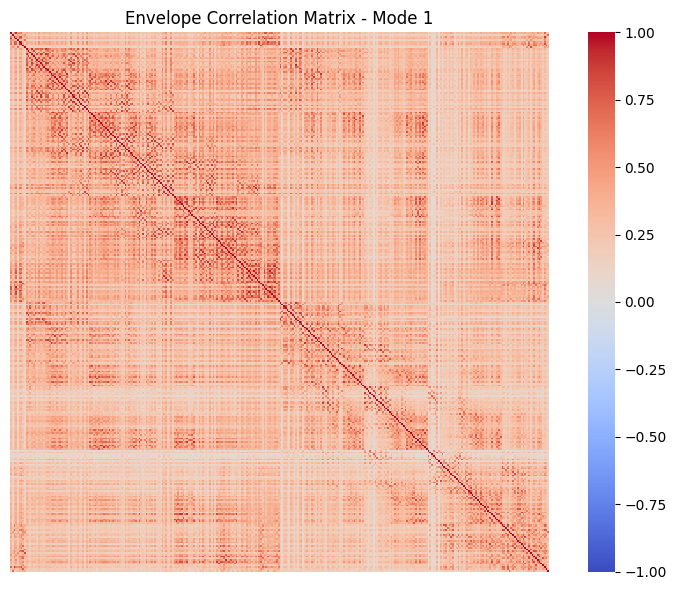

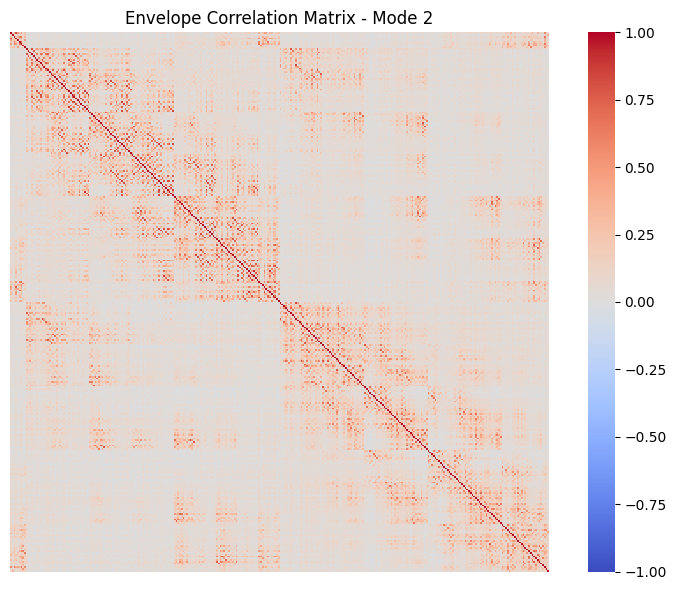

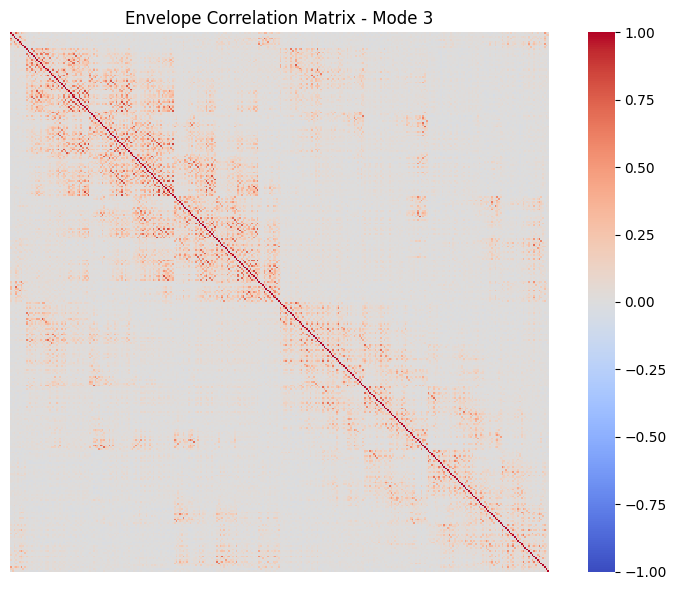

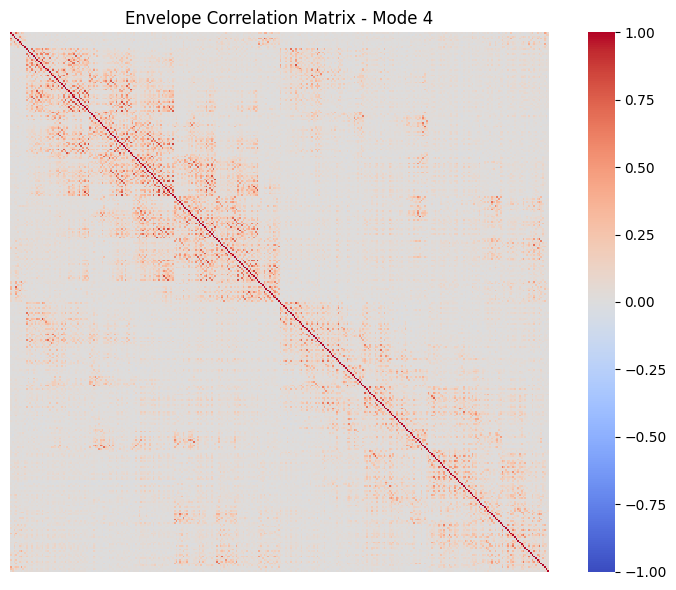

In [87]:
# Display each mode's correlation matrix
for mode_idx, corr in correlation_matrices.items():
    plot_correlation_matrix(corr, mode_idx)

In [296]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def reorder_matrix_hierarchical(matrix):
    """
    Reorder a correlation matrix based on hierarchical clustering.
    """
    linkage_result = linkage(matrix, method='ward')
    order = leaves_list(linkage_result)
    reordered = matrix[np.ix_(order, order)]
    return reordered

def plot_corr_matrices_grid(corr_dict, mode_indices=[0, 1, 2, 3, 4], cmap="coolwarm", vmin=-1, vmax=1):
    """
    Plot reordered correlation matrices in a 1-row grid.
    """
    n_modes = len(mode_indices)
    fig, axes = plt.subplots(1, n_modes, figsize=(5 * n_modes, 4))

    if n_modes == 1:
        axes = [axes]  # Ensure iterable

    for i, mode_idx in enumerate(mode_indices):
        corr = corr_dict[mode_idx]
        reordered = reorder_matrix_hierarchical(corr)

        ax = axes[i]
        sns.heatmap(
            reordered,
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            xticklabels=False,
            yticklabels=False,
            cbar=(i == n_modes - 1),  # Show colorbar only once
            square=True,
        )
        ax.set_title(f"Mode {mode_idx}", fontsize=14)

    plt.suptitle("Envelope Correlation Matrices", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


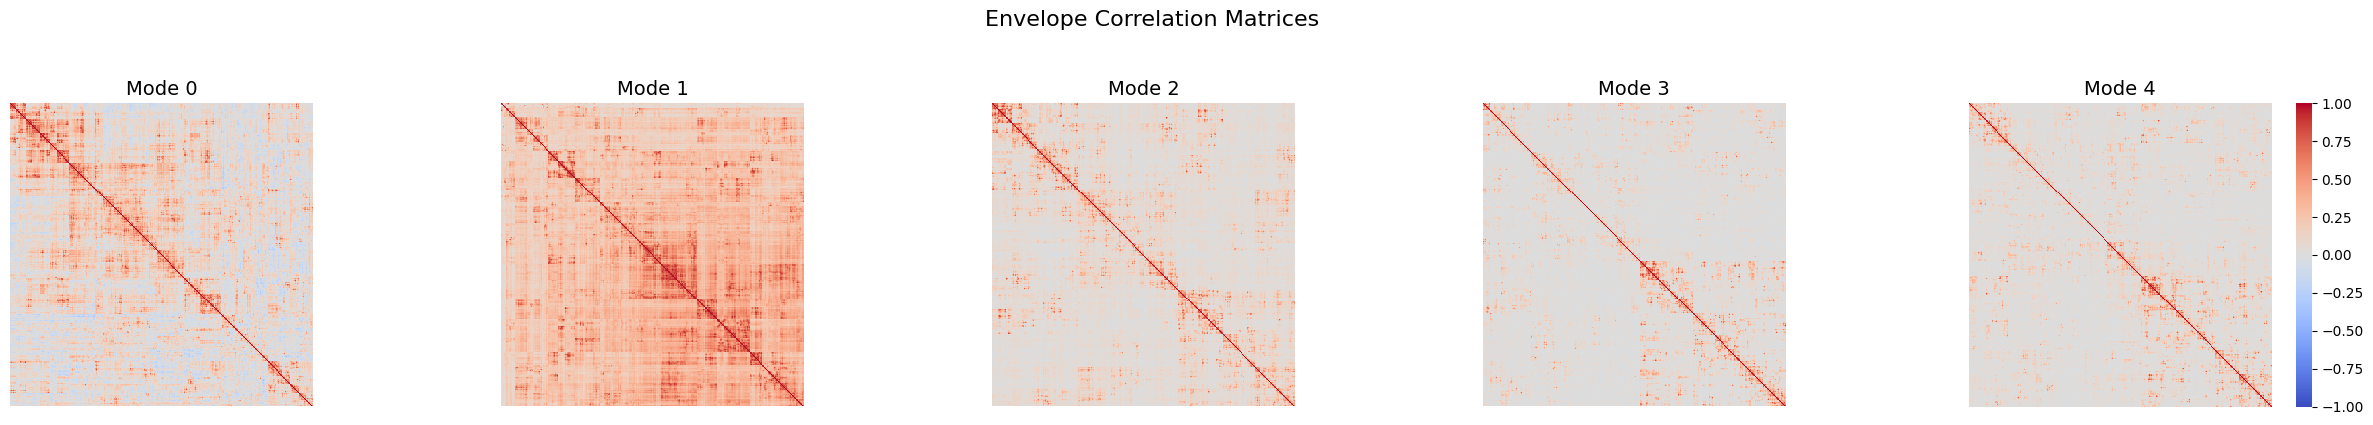

In [297]:
# # Load envelopes
# envelopes = load_all_envelopes("../results/real/MVMD/envelopes")

# # Compute correlation matrices
# correlation_matrices = compute_envelope_correlation_per_mode(envelopes)

# Plot reordered matrices
plot_corr_matrices_grid(correlation_matrices, mode_indices=[0, 1, 2, 3, 4])


In [90]:
def build_modes_df_mvmd(u_path, envelope_dir, raw_path=None):
    """
    Build modes_df for MVMD from decomposed signals and saved envelopes.

    Parameters:
    - u_path: path to .npz file containing MVMD result (`u`)
    - envelope_dir: path to folder containing meg_channel_{i}_envelopes.npy
    - raw_path: optional path to raw MEG file (to extract channel names)

    Returns:
    - modes_df: DataFrame with columns: channel, channel_name, mode_idx, signal, envelope
    """
    # === Load MVMD results ===
    data = np.load(u_path)
    u = data['u']  # Shape: (n_modes, n_samples, n_channels)
    n_modes, n_samples, n_channels = u.shape

    # === Load channel names ===
    channel_names = [f"MEG {i:03d}" for i in range(n_channels)]
    if raw_path is not None:
        raw = mne.io.read_raw_fif(raw_path, preload=False)
        channel_names = raw.info['ch_names']

    # === Build DataFrame ===
    rows = []
    for ch in range(n_channels):
        envelope_path = os.path.join(envelope_dir, f"meg_channel_{ch}_envelopes.npy")
        if not os.path.exists(envelope_path):
            print(f"⚠️ Missing envelope for channel {ch}. Skipping.")
            continue
        envelopes = np.load(envelope_path)  # Shape: (n_modes, n_samples)

        for m in range(n_modes):
            signal = u[m, :, ch]
            envelope = envelopes[m]
            rows.append({
                "channel": ch,
                "channel_name": channel_names[ch],
                "mode_idx": m,
                "signal": signal,
                "envelope": envelope
            })

    modes_df = pd.DataFrame(rows)
    return modes_df


In [93]:
import pandas as pd 
modes_df = build_modes_df_mvmd(
    u_path="../results/real/MVMD/modes/mvmd_modes_sub-01.npz",
    envelope_dir="../results/real/MVMD/envelopes",
    raw_path="../data/sub-01_ses-01_task-rest_proc-filt_raw.fif"  # optional
)


Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.


In [97]:
# Save the modes_df to a pickle file
modes_df.to_pickle("../results/real/MVMD/modes_df.pkl")

print("✅ modes_df saved to ../results/real/MVMD/modes_df.pkl")


✅ modes_df saved to ../results/real/MVMD/modes_df.pkl


In [95]:
modes_df

channel channel_name  mode_idx  \
0           0       BIO001         0   
1           0       BIO001         1   
2           0       BIO001         2   
3           0       BIO001         3   
4           0       BIO001         4   
...       ...          ...       ...   
1525      305      MEG2511         0   
1526      305      MEG2511         1   
1527      305      MEG2511         2   
1528      305      MEG2511         3   
1529      305      MEG2511         4   

                                                 signal  \
0     [-2.843621e-13, -2.8543108e-13, -2.8430432e-13...   
1     [1.1857855e-13, 1.09172145e-13, 9.490559e-14, ...   
2     [6.6796395e-14, 5.6515576e-14, 4.088599e-14, 1...   
3     [2.1144913e-15, -1.7640684e-14, -2.3901067e-16...   
4     [7.540389e-15, -2.7545533e-14, 1.7473209e-14, ...   
...                                                 ...   
1525  [2.0871878e-12, 2.0852417e-12, 2.0592928e-12, ...   
1526  [-1.5327405e-12, -1.47434e-12, -1.3825695e-12,...   
1527  [-1.982738e-13, -9.015896e-14, 5.3477337e-14, ...   
1528  [-7.378038e-14, 2.7396752e-14, -1.2194662e-13,...   
1529  [-5.3836357e-13, 1.2079579e-12, -1.8462588e-12...   

                                               envelope  
0     [1.8991175277337236e-13, 1.949337501312709e-13...  
1     [2.2442224334863307e-14, 2.376410395234837e-14...  
2     [4.6091633249889866e-14, 4.6866271985208235e-1...  
3     [8.378910053578794e-15, 9.644070650849813e-15,...  
4     [6.803225060261981e-15, 7.87330761703323e-15, ...  
...                                                 ...  
1525  [6.4400676631770626e-12, 6.4692457120429925e-1...  
1526  [1.0758842818384129e-12, 1.0840844281295725e-1...  
1527  [4.441028436923816e-13, 4.652122328856201e-13,...  
1528  [1.8689066407732297e-13, 2.288417936049947e-13...  
1529  [5.18671260454906e-13, 6.199690283717474e-13, ...  

[1530 rows x 5 columns]

In [ ]:
scaling_ranges = [(6, 12)]
q_vals = np.arange(-3, 6)
summary_records = []
methods = ["VMD"]

In [ ]:

 A quelle fréquence correspond le j 
# integrate 1
# bias correction -> 0.3.2 branch github
# PCA/ICA : modele linéaire, suppose que le mélange est constant 
# Amplitude/Phase modes à revoir
# Question à poser à Merlin : Sur le pic fréquence VS la décorrlation (phrase)





In [1]:
from pymultifracs.utils import scale2freq

In [5]:
scale2freq(8, 250, 'db3')

np.float64(0.78125)

In [2]:
?scale2freq

Signature: scale2freq(scale, sfreq, wt_name='db3')
Docstring: Returns the frequency associated to a scale.
File:      ~/Desktop/project/MCNN/pymultifracs/pymultifracs/utils.py
Type:      function


📊 Processing mode_idx = 0


<Figure size 800x400 with 0 Axes>

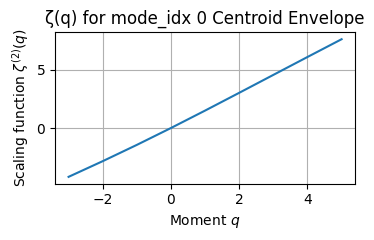

<Figure size 800x400 with 0 Axes>

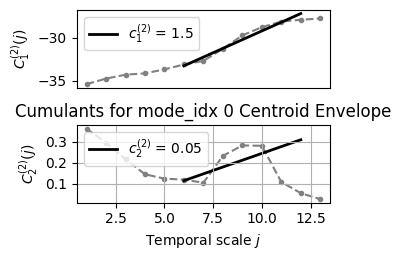

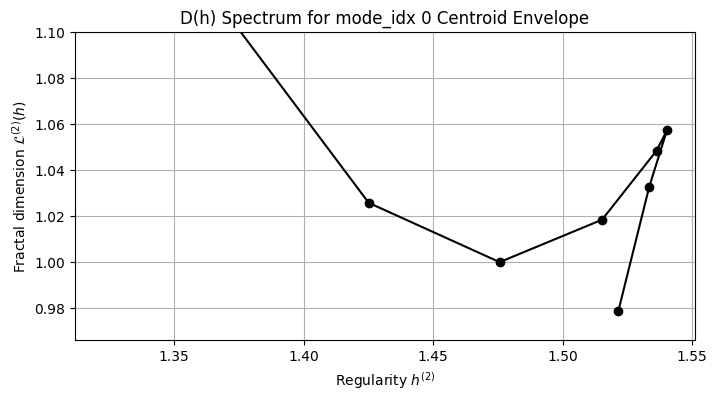


📊 Processing mode_idx = 1


<Figure size 800x400 with 0 Axes>

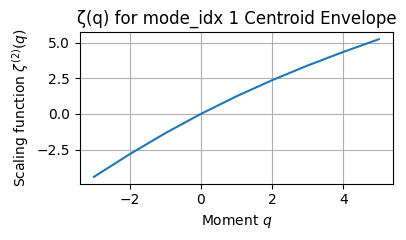

<Figure size 800x400 with 0 Axes>

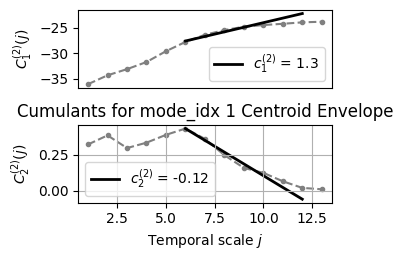

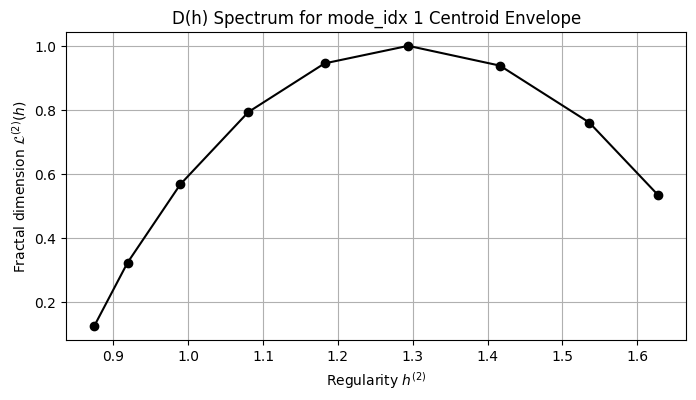


📊 Processing mode_idx = 2


<Figure size 800x400 with 0 Axes>

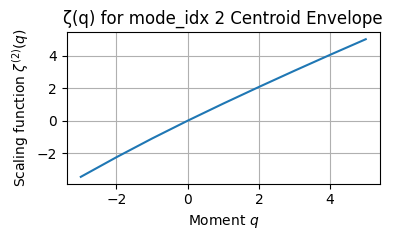

<Figure size 800x400 with 0 Axes>

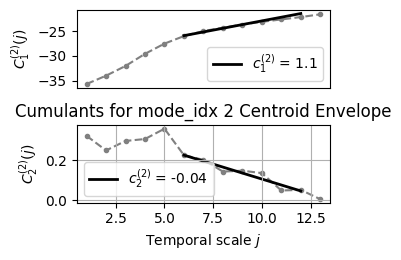

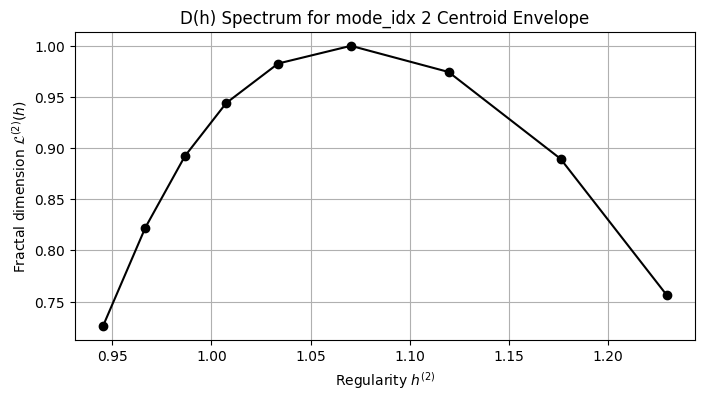


📊 Processing mode_idx = 3


<Figure size 800x400 with 0 Axes>

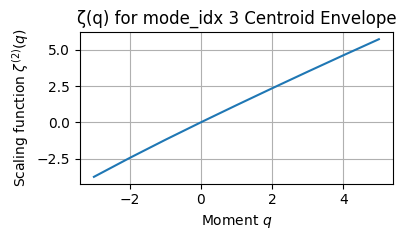

<Figure size 800x400 with 0 Axes>

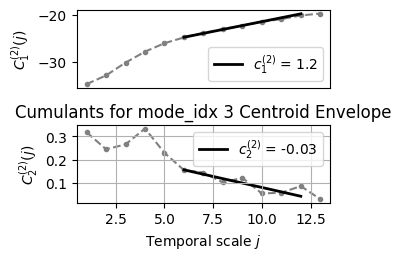

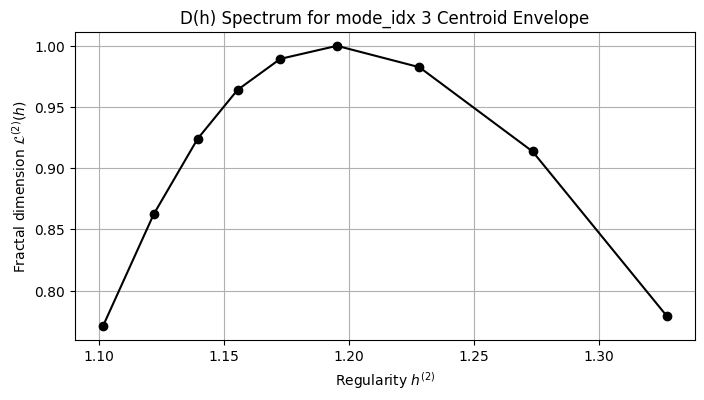


📊 Processing mode_idx = 4


<Figure size 800x400 with 0 Axes>

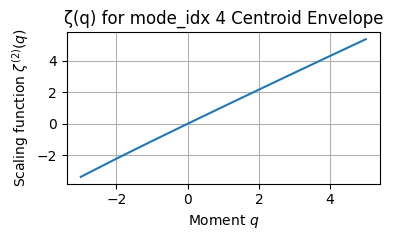

<Figure size 800x400 with 0 Axes>

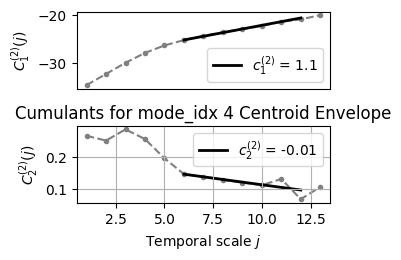

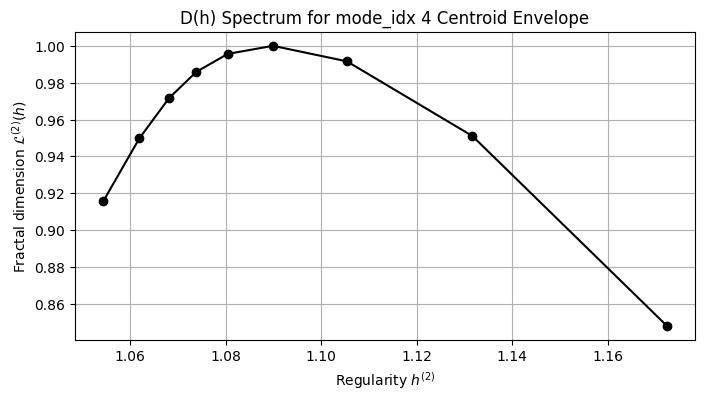

In [105]:
summary_df = mfa_on_envelope_centroids(
    modes_df=modes_df,
    scaling_ranges=scaling_ranges,
    q_vals=q_vals,
    output_base="../results/real/MVMD/",
    group_by="mode_idx"
)


In [115]:
from scipy.signal import welch
import numpy as np

def compute_peak_frequency(signal, fs=250):
    freqs, psd = welch(signal, fs=fs, nperseg=1024)
    peak_freq = freqs[np.argmax(psd)]
    return peak_freq


In [116]:
def compute_peak_frequencies_on_modes(u, fs=250):
    n_modes, n_samples, n_channels = u.shape
    peak_freqs = {}

    for mode_idx in range(n_modes):
        mode_freqs = []
        for ch_idx in range(n_channels):
            signal = u[mode_idx, :, ch_idx]
            pfreq = compute_peak_frequency(signal, fs)
            mode_freqs.append(pfreq)
        peak_freqs[mode_idx] = mode_freqs

    return peak_freqs


In [117]:
pfreqs_dict = compute_peak_frequencies_on_modes(u, fs=250)


In [118]:
for mode_idx, freqs in pfreqs_dict.items():
    print(f"Mode {mode_idx}: Avg. Peak Frequency = {np.mean(freqs):.2f} Hz")


Mode 0: Avg. Peak Frequency = 0.24 Hz
Mode 1: Avg. Peak Frequency = 10.14 Hz
Mode 2: Avg. Peak Frequency = 20.40 Hz
Mode 3: Avg. Peak Frequency = 56.05 Hz
Mode 4: Avg. Peak Frequency = 105.01 Hz


In [119]:
summary_df = pd.DataFrame([
    {"Mode": mode_idx, "Avg_Peak_Freq": np.mean(freqs)}
    for mode_idx, freqs in pfreqs_dict.items()
])
summary_df

Mode  Avg_Peak_Freq
0     0       0.244141
1     1      10.140612
2     2      20.396114
3     3      56.052613
4     4     105.009191